In [3]:
from nexar_videos import *

In [4]:
df_labels_train = pd.read_parquet('master_train.parquet')[['id', 'Collision','Time-of-collision','Impact-Side','Light-Conditions','Scene','Weather']].rename(columns={'id':'incident_id'})
df_labels_test = pd.read_parquet('master_test.parquet')[['incident_id', 'Collision','Time-of-collision','Impact-Side','Light-Conditions','Scene','Weather']].drop_duplicates(subset='incident_id')
df_labels = pd.concat([df_labels_train,df_labels_test])

In [5]:
pd.read_parquet('master_test.parquet')['Impact-Side'].value_counts()

Impact-Side
Front    286
Right     34
Left      22
Name: count, dtype: int64

In [6]:
df_labels.to_csv('competition_labels.csv',index=False)

In [7]:
df_labels_collision = df_labels.loc[df_labels['Collision']=='Visible'].reset_index(drop=True)

In [8]:
import os
import pandas as pd

search_dirs = [
    "../data/research-nvidia-data/nvidia-1",
    "../data/research-nvidia-data/nvidia-2"
]

incident_ids = df_labels_collision['incident_id'].tolist()

existing_ids = []
missing_ids = []

for incident_id in incident_ids:
    found = False
    for base_dir in search_dirs:
        if os.path.isdir(os.path.join(base_dir, incident_id)):
            existing_ids.append(incident_id)
            found = True
            break
    if not found:
        missing_ids.append(incident_id)

df_existing = pd.DataFrame(existing_ids, columns=["incident_id"])
df_missing = pd.DataFrame(missing_ids, columns=["incident_id"])

In [9]:
len(df_existing), len(df_missing)

(627, 407)

In [10]:
df_nvidia_delivery = pd.read_csv('nvidia_delivery.csv')
df_sample_normal = df_nvidia_delivery.loc[df_nvidia_delivery['video_type']=='Normal'].sample(2000).reset_index(drop=True)[['id']].rename(columns={'id':'incident_id'})
df_nvidia_delivery['video_type'].value_counts()

video_type
Normal            37150
Collision          8484
Near Collision     8425
Name: count, dtype: int64

In [11]:
df_nvidia_delivery.loc[df_nvidia_delivery['video_type']!='Normal']['id']

0                 5e073a574be1698125dbcc385216291b
1                 70dcf840ec17848bcd97d8c4dfc4e821
2                 0be98616c5dba282f6396d377903131e
3                 16bf060355d52988d4c2f59a3417fdd2
4                 19e853be42e7050786a5fb56cbcf2900
                           ...                    
54054    incident-ee80e5b655f6b1ec3d7c592c608fc776
54055    incident-f7dfa1e91dba4b15a17fbb334efe17c7
54056    incident-f7e6ddf483233bb61c697cb48d4398d2
54057    incident-f7ea6105ea2738bfe4255894f71eaecc
54058    incident-fc3b9934228c277ec1acd8f9254bbec8
Name: id, Length: 16909, dtype: object

In [12]:
df_sample_normal['video_type'] = 'Normal'
df_existing['video_type'] = 'Collision'
df_for_train = pd.concat([df_sample_normal,df_existing])
df_dataloader = df_nvidia_delivery.loc[df_nvidia_delivery['id'].isin(df_for_train['incident_id'])].reset_index(drop=True).drop('video_type',axis=1)
df_for_train = df_for_train.rename(columns={'incident_id': 'id'})
df_dataloader = df_dataloader.merge(df_for_train, on='id', how='right')

non_collision_ids = df_nvidia_delivery.loc[~(df_nvidia_delivery['video_type'] == 'Collision'), 'id']
filtered_df = df_dataloader[~(df_dataloader['id'].isin(non_collision_ids) & (df_dataloader['video_type'] == 'Collision'))]
filtered_df

id       state               city  \
0     8c312265cf7203a0412655202964a875     Arizona           Glendale   
1     0d36f22e291ecd181b6c807f9704f533    New York      New York City   
2     5a22a57a2c7eae5c20b304c21f337a7e  California       Sierra Madre   
3     5d603c7fedaa293fba02ac9e16c4cbfa    New York      New York City   
4     a41b9cd9a457e568d4f145df8b1fd2a4    New York            Jamaica   
...                                ...         ...                ...   
2616  e6e00469a47e8b43aeaf3a3f90262bd1  California           Van Nuys   
2617  8c3808a59081813397aae42a8bd933c1    New York            Jamaica   
2623  ce08c904877338023ca22753bfbcd908    New York           Brooklyn   
2624  1d9da010ae3eb02b2da19459c22ad320    New York  Borough of Queens   
2626  41690b46cd97a12febd734a14102c922         NaN                NaN   

       latitude   longitude  avg_speed  max_speed      course  \
0     33.536919 -112.116923  17.036972  19.551672  178.811699   
1     40.717024  -73.998322   7.317000   8.620000  114.701119   
2     34.148054 -118.067857  16.181200  17.859000  178.562004   
3     40.739640  -74.006400   0.000000   0.000000   24.869291   
4     40.657032  -73.795331  17.031160  17.456360  180.323730   
...         ...         ...        ...        ...         ...   
2616  34.213665 -118.448712  18.157900  20.343000  358.741570   
2617  40.682341  -73.807774   1.700200   3.119000    4.162306   
2623  40.669395  -73.920022   0.451300   2.962000   61.951574   
2624  40.711224  -73.836697  16.549196  17.698296   44.681934   
2626        NaN         NaN        NaN        NaN         NaN   

      timestamp_millis resolution  ...   g_max_y   g_std_y g_amplitude_y  \
0         1.637379e+12       720p  ...  0.934464  0.111824      0.921010   
1         1.668732e+12       720p  ...  0.491551  0.068392      0.475241   
2         1.607833e+12       720p  ...  0.699830  0.118392      0.620645   
3         1.670611e+12       720p  ...  1.144686  0.094369      1.136141   
4         1.669856e+12       720p  ...  1.523616  0.074731      1.462943   
...                ...        ...  ...       ...       ...           ...   
2616      1.612725e+12       720p  ...  6.108953  0.288963      6.034635   
2617      1.662752e+12       720p  ...  4.056634  0.173056      4.041525   
2623      1.673303e+12       720p  ...  6.243980  0.281698      6.207515   
2624      1.673730e+12       720p  ...  2.211170  0.185307      2.201675   
2626               NaN        NaN  ...       NaN       NaN           NaN   

        g_mean  g_median     g_min     g_max     g_std  g_amplitude  \
0     0.162226  0.134566  0.013455  0.934464  0.111824     0.921010   
1     0.188111  0.168920  0.016309  0.491551  0.068392     0.475241   
2     0.304615  0.262569  0.079185  0.699830  0.118392     0.620645   
3     0.161121  0.135752  0.008545  1.144686  0.094369     1.136141   
4     0.174662  0.166057  0.060673  1.523616  0.074731     1.462943   
...        ...       ...       ...       ...       ...          ...   
2616  0.410946  0.474826  0.074317  6.108953  0.288963     6.034635   
2617  0.190962  0.239377  0.015110  4.056634  0.173056     4.041525   
2623  0.150632  0.096845  0.036465  6.243980  0.281698     6.207515   
2624  0.147775  0.100195  0.009496  2.211170  0.185307     2.201675   
2626       NaN       NaN       NaN       NaN       NaN          NaN   

      video_type  
0         Normal  
1         Normal  
2         Normal  
3         Normal  
4         Normal  
...          ...  
2616   Collision  
2617   Collision  
2623   Collision  
2624   Collision  
2626   Collision  

[2312 rows x 36 columns]

In [13]:
df_labels = df_labels.rename(columns={'incident_id': 'id'})
filtered_df = filtered_df.merge(df_labels, on='id', how='left')
filtered_df['Time-of-collision'] = filtered_df['Time-of-collision'].fillna(20)

In [14]:
filtered_df.video_type.value_counts()

video_type
Normal       2000
Collision     312
Name: count, dtype: int64

In [15]:
df_dataloader.to_csv('df_dataloader.csv',index=False)

In [27]:
example_id = "incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11"

# Directories to search
search_dirs = [
    "../data/research-nvidia-data/nvidia-1",
    "../data/research-nvidia-data/nvidia-2"
]

# Find the video path
result = find_video_path(example_id, search_dirs)
result

{'found': True,
 'video_path': '../data/research-nvidia-data/nvidia-2/incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11/incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11.mp4',
 'sensor_path': None,
 'directory': '../data/research-nvidia-data/nvidia-2',
 'video_format': 'incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11.mp4',
 'message': 'Found video in ../data/research-nvidia-data/nvidia-2 but sensor data is missing'}

In [28]:
copy_video_file(
    '../data/research-nvidia-data/nvidia-2/incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11/incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11.mp4',
    'incident-0-fb0292d2-83a2-4092-a93f-3a23e1878e11.mp4'
)

In [24]:
plot_acceleration(
    '../data/research-nvidia-data/nvidia-1/2991664e6704ae0679cedce0795832b5/signals/Dashcam-Accelerometer_Acceleration.csv'
)

KeyError: 'time_sec'

In [9]:
output_path = 'metadata_with_rel_peaks.csv'
metadata_df = df_sample

base_dirs = ["../data/research-nvidia-data/nvidia-1", "../data/research-nvidia-data/nvidia-2"]
sample_ids = metadata_df['id'].values[:10].tolist() if len(metadata_df) > 0 else []

structure_info = infer_directory_structure(
    base_dirs=base_dirs,
    sample_ids=sample_ids
)

metadata_with_peaks = add_peak_acceleration_timestamps(
    metadata_df=metadata_df,
    base_dirs=base_dirs,
    sensor_subdir='signals',
    output_path="metadata_with_peaks.csv",
    try_alternative_formats=True
)

metadata_with_rel_peaks = convert_absolute_to_relative_time(
    metadata_df=metadata_with_peaks,
    base_dirs=base_dirs,
    sensor_subdir='signals',
    output_path="metadata_with_rel_peaks.csv",
    try_alternative_formats=True
)

Finding peak acceleration:   0%|          | 0/1167 [00:00<?, ?it/s]

Converting timestamps:   0%|          | 0/1167 [00:00<?, ?it/s]

In [10]:
metadata_with_rel_peaks['video_type'].value_counts()

video_type
Collision         389
Near Collision    389
Normal            389
Name: count, dtype: int64

<Axes: >

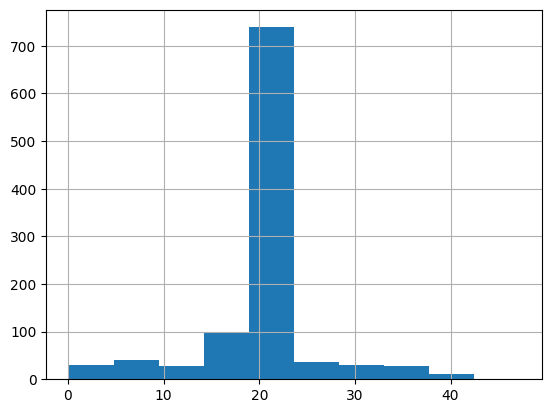

In [11]:
metadata_with_rel_peaks['peak_accel_rel_time_sec'].hist()

In [12]:
print(set(pd.read_csv(output_path)['video_type']))

{'Near Collision', 'Normal', 'Collision'}


In [13]:
from collections import Counter
df = pd.read_csv(output_path)
print(Counter(df['video_type']))
print(Counter(NvidiaDashcamDataset(df, base_dirs, skip_missing=True).metadata_df['video_type']))

Counter({'Collision': 389, 'Near Collision': 389, 'Normal': 389})


Checking files:   0%|          | 0/1167 [00:00<?, ?it/s]

Counter({'Collision': 389, 'Near Collision': 389, 'Normal': 389})


In [14]:
base_dirs = ["../data/research-nvidia-data/nvidia-1", "../data/research-nvidia-data/nvidia-2"]

# Create datasets
train_data, val_data, test_data = create_datasets_with_multiple_dirs(
    base_dirs=base_dirs,
    metadata_csv=output_path,
    seed=42,
    sensor_subdir='signals',
    sample_strategy='metadata_time',
    time_column='peak_accel_rel_time_sec'
)

Checking files:   0%|          | 0/1167 [00:00<?, ?it/s]

  ../data/research-nvidia-data/nvidia-1: 449 files
  ../data/research-nvidia-data/nvidia-2: 592 files


Checking files:   0%|          | 0/728 [00:00<?, ?it/s]

Checking files:   0%|          | 0/156 [00:00<?, ?it/s]

Checking files:   0%|          | 0/157 [00:00<?, ?it/s]

In [15]:
train_data

🎥 NvidiaDashcamDataset Summary
══════════════════════════════
📊 Total Videos: 728
🎞️ FPS: 10
⏱️ Duration: 5 seconds

📋 Class Distribution:
   Collision      │  184 ( 25.3%) █████░░░░░░░░░░░░░░░
   Near Collision │  272 ( 37.4%) ███████░░░░░░░░░░░░░
   Normal         │  272 ( 37.4%) ███████░░░░░░░░░░░░░

🔧 Training Mode: ✓
🔍 Sampling Strategy: metadata_time

In [16]:
view = train_data.show_batch(
    m=3,
    rows_per_page=8,
    save_videos=False,
    video_width=320
)

In [17]:
batch_size = 12

loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

# Get a single batch
batch = next(iter(loader))

# Print batch information
print("Batch contents:")
print(f"- Frames: {batch['frames'].shape}, {batch['frames'].dtype}")
print(f"- Sensor: {batch['sensor'].shape}, {batch['sensor'].dtype}")
print(f"- Target: {batch['target']}")
print(f"- IDs: {batch['id']}")

Batch contents:
- Frames: torch.Size([12, 50, 224, 224, 3]), torch.float32
- Sensor: torch.Size([12, 50, 4]), torch.float32
- Target: ['Collision', 'Collision', 'Near Collision', 'Normal', 'Collision', 'Normal', 'Normal', 'Normal', 'Near Collision', 'Near Collision', 'Normal', 'Near Collision']
- IDs: ['incident-0-ccc2560d-7f05-4298-8572-a3156266cac4', 'incident-637ce71592bc86e4c1edf7d76fbaedfc', 'c877d255-6aed-46a3-b533-28bdda9bc11d', '3fb32e16eafeb66cb22a6f98c126c229', '0fc478e5bdad5e5e555e4c0aed953ce4', 'b70435dab5e9dc5b25dd451704a2e90c', 'e9930cf1a6aa6a6fe24dfd9e622a259e', '63fd8676485b42d9898cb26ebb1ec0b7', '1c74f60677e3713d7770714d038c6613', '908cde74-2f92-46ad-8314-c6ca0fa49b48', '4eda108f0eb40b695b904e9fbb1796b0', '07b737d1-52d0-4da1-aa3b-fa3e75b1eb25']


In [6]:
import boto3
import requests
import json
import time
import os
from botocore.exceptions import ClientError

# ========== CONFIG ==========
source_bucket = "nexar-deep-learning"
target_bucket = "deep-learning-annotation"
source_s3_key = "ronig/Waymo/collision_classification_short/Collision/middle_6_clgr0u8kc0bbf07903o02fp0j.mp4"

# Target path for anonymization output
upload_s3_prefix = "video-anonymizer/ronig/Waymo/collision_classification_short/Collision"
output_s3_key = f"{upload_s3_prefix}/{os.path.basename(source_s3_key)}"
download_path = "anonymized_output.mp4"

# ========== STEP 0: COPY VIDEO TO TARGET BUCKET ==========
print("📤 Copying video to deep-learning-annotation bucket...")
s3 = boto3.client('s3')

copy_source = {
    'Bucket': source_bucket,
    'Key': source_s3_key
}
try:
    s3.copy(copy_source, target_bucket, source_s3_key)
    print("✅ Video copied successfully.")
except ClientError as e:
    print("❌ Failed to copy video:")
    print(e)
    exit(1)

# ========== STEP 1: SUBMIT ANONYMIZATION REQUEST ==========
anonymizer_api_url = "https://utility-api.prod-or.k.nexar.mobi/api/v1/video/anonymize"
headers = {"Content-Type": "application/json"}

payload = {
    "upload_s3_prefix": upload_s3_prefix,
    "use_existing_frames": False,
    "video_s3_bucket": target_bucket,
    "video_s3_refs": [source_s3_key],
    "video_suffixes": [".mp4", ".mov"]
}

print("📡 Sending anonymization request...")
response = requests.post(anonymizer_api_url, headers=headers, data=json.dumps(payload), timeout=15)

if response.status_code == 200:
    print("✅ Anonymization request submitted successfully.")
else:
    print("❌ Failed to submit anonymization request.")
    print(response.status_code, response.text)
    exit(1)

# ========== STEP 2: WAIT FOR OUTPUT ==========
max_wait_seconds = 300
interval_seconds = 10
waited = 0

print("⏳ Waiting for anonymized video to appear in S3...")

while waited < max_wait_seconds:
    try:
        s3.head_object(Bucket=target_bucket, Key=output_s3_key)
        print(f"✅ Anonymized video found in S3 after {waited} seconds.")
        break
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            print(f"⌛ Not ready yet... waited {waited} seconds")
        else:
            raise
    time.sleep(interval_seconds)
    waited += interval_seconds
else:
    print("❌ Timeout: anonymized video did not appear in S3 within 5 minutes.")
    exit(1)

# ========== STEP 3: DOWNLOAD ==========
print(f"⬇️ Downloading from s3://{target_bucket}/{output_s3_key} to {download_path}")
s3.download_file(target_bucket, output_s3_key, download_path)
print(f"✅ Download complete: {download_path}")


📤 Copying video to deep-learning-annotation bucket...
❌ Failed to copy video:
An error occurred (AccessDenied) when calling the CopyObject operation: User: arn:aws:sts::858980959072:assumed-role/RonigNodePermissionsRole/i-0f5af19fdef407690 is not authorized to perform: s3:PutObject on resource: "arn:aws:s3:::deep-learning-annotation/ronig/Waymo/collision_classification_short/Collision/middle_6_clgr0u8kc0bbf07903o02fp0j.mp4" because no identity-based policy allows the s3:PutObject action
📡 Sending anonymization request...
✅ Anonymization request submitted successfully.
⏳ Waiting for anonymized video to appear in S3...
⌛ Not ready yet... waited 0 seconds
⌛ Not ready yet... waited 10 seconds
⌛ Not ready yet... waited 20 seconds
⌛ Not ready yet... waited 30 seconds
⌛ Not ready yet... waited 40 seconds
⌛ Not ready yet... waited 50 seconds
⌛ Not ready yet... waited 60 seconds
⌛ Not ready yet... waited 70 seconds
⌛ Not ready yet... waited 80 seconds
⌛ Not ready yet... waited 90 seconds
⌛ Not 

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [4]:
output_s3_key

'video-anonymizer/ronig/Waymo/collision_classification_short/Collision/middle_6_clgr0u8kc0bbf07903o02fp0j.mp4'

In [5]:
upload_s3_prefix

'video-anonymizer/ronig/Waymo/collision_classification_short/Collision'